In [184]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [185]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv')

In [186]:
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [187]:
#Keep only some columns
df2 = df[['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year', 'fuel_efficiency_mpg']]

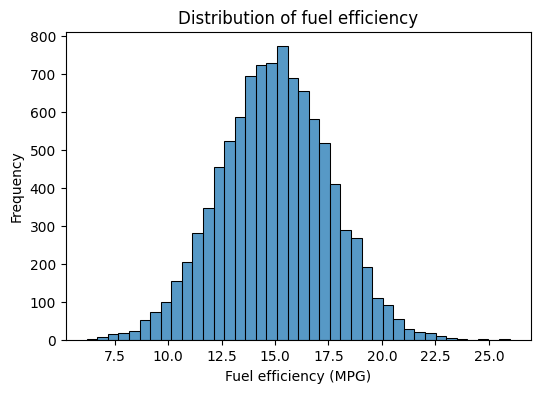

In [188]:
#Exploratory data analysis
plt.figure(figsize=(6, 4))

sns.histplot(df2.fuel_efficiency_mpg, bins=40)
plt.ylabel('Frequency')
plt.xlabel('Fuel efficiency (MPG)')
plt.title('Distribution of fuel efficiency')

plt.show()

In [189]:
#Q1: There's one column with missing values. What is it?
col_missing_values = df2.isnull().any()
col_missing_values

engine_displacement    False
horsepower              True
vehicle_weight         False
model_year             False
fuel_efficiency_mpg    False
dtype: bool

In [190]:
#Q2: What's the median (50% percentile) for variable 'horsepower'?
median_hp = df['horsepower'].median()
print("Median horsepower:", f"{median_hp}")

Median horsepower: 149.0


In [191]:
#Prepare and split the dataset

np.random.seed(42)
n = len(df2)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df2.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

In [192]:
y_train = np.log1p(df_train.fuel_efficiency_mpg.values)
y_val = np.log1p(df_val.fuel_efficiency_mpg.values)
y_test = np.log1p(df_test.fuel_efficiency_mpg.values)

del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

In [193]:
len(df_train), len(df_val), len(df_test)

(5824, 1940, 1940)

In [194]:
len(y_train), len(y_val), len(y_test)

(5824, 1940, 1940)

In [195]:
df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

In [196]:
#Question 3: Deal with the missing values
#df_train['horspeower_0'] = df_train['horsepower'].fillna(0)

horspower_traning_mean = df_train['horsepower'].mean()
#df_train['horspeower_mean'] = df_train['horsepower'].fillna(horspower_traning_mean)

In [197]:
#Linear regression

def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]


In [198]:
base = ['engine_displacement', 'horsepower', 'vehicle_weight', 
        'model_year']

In [199]:
#For replacing NaN with 0
def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

#For replacing NaN with mean horsepower of traning data
def prepare_X2(df):
    df_num = df[base]
    df_num = df_num.fillna(horspower_traning_mean)
    X = df_num.values
    return X

#RMSE

def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [200]:
df_train

,engine_displacement,horsepower,vehicle_weight,model_year
0,220,144.0,2535.887591,2009
1,160,141.0,2741.170484,2019
2,230,155.0,2471.880237,2017
3,150,206.0,3748.164469,2015
4,300,111.0,2135.716359,2006
...,...,...,...,...
5819,260,139.0,2606.972984,2009
5820,280,132.0,4004.214323,2014
5821,210,152.0,2500.175687,2020
5822,250,154.0,2254.313245,2002


In [201]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

y_pred = w_0 + X_train.dot(w)
rmse_0 = rmse(y_train, y_pred)
rmse_0

np.float64(0.039086325392652485)

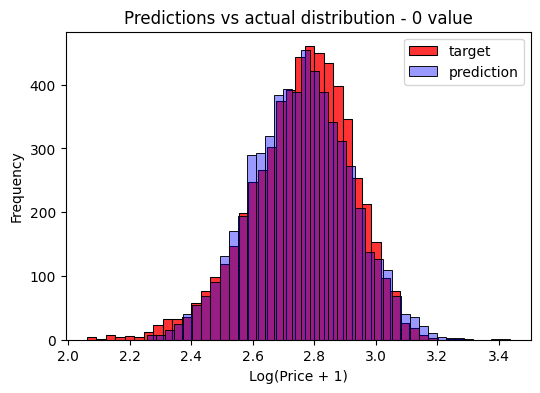

In [202]:
plt.figure(figsize=(6, 4))

sns.histplot(y_train, label='target', color='red', alpha=0.8, bins=40)
sns.histplot(y_pred, label='prediction', color='blue', alpha=0.4, bins=40)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Predictions vs actual distribution - 0 value')

plt.show()

In [203]:
#Model validation
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)

rmse_0_val = rmse(y_val, y_pred)

In [204]:
print(f"RMSE for 0: {round(rmse_0, 2)}, RMSE for 0 val: {round(rmse_0_val, 2)}")

RMSE for 0: 0.04, RMSE for 0 val: 0.04


In [205]:
X_train = prepare_X2(df_train)
w_0, w = train_linear_regression(X_train, y_train)

In [206]:
y_pred = w_0 + X_train.dot(w)

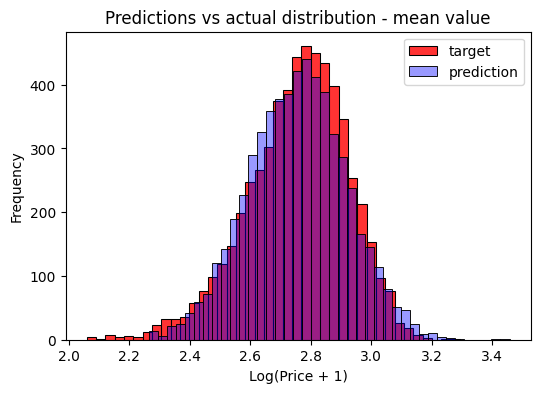

In [207]:
plt.figure(figsize=(6, 4))

sns.histplot(y_train, label='target', color='red', alpha=0.8, bins=40)
sns.histplot(y_pred, label='prediction', color='blue', alpha=0.4, bins=40)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Predictions vs actual distribution - mean value')

plt.show()

In [208]:
rmse_mean = rmse(y_train, y_pred)
rmse_mean

np.float64(0.03581083785900231)

In [209]:
#Model validation
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X2(df_val)
y_pred = w_0 + X_val.dot(w)

rmse_mean_val = rmse(y_val, y_pred)

In [210]:
print(f"RMSE for mean: {round(rmse_mean, 2)}, RMSE for 0 val: {round(rmse_mean_val, 2)}")

RMSE for mean: 0.04, RMSE for 0 val: 0.04


In [212]:
#For training dataset
print(f"RMSE for 0: {round(rmse_0, 2)}, RMSE for mean: {round(rmse_mean, 2)}")

RMSE for 0: 0.04, RMSE for mean: 0.04


In [213]:
#For validation dataset
print(f"RMSE for 0: {round(rmse_0_val, 2)}, RMSE for mean: {round(rmse_mean_val, 2)}")

RMSE for 0: 0.04, RMSE for mean: 0.04
